In [5]:
# ============================================
# Cell 1: 导入必要的库
# ============================================
"""
MACD策略回测学习笔记
作者：AI Assistant
目的：学习MACD技术指标和回测的基本概念
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

print("📚 MACD策略回测学习系统")
print("="*50)
print("环境准备完成！")

📚 MACD策略回测学习系统
环境准备完成！


In [6]:
# ============================================
# Cell 2: 策略参数配置中心
# ============================================
"""
⚙️ 所有可调整的参数都在这里
修改这些参数来观察不同设置对策略的影响
"""

# MACD指标参数
MACD_PARAMS = {
    'fast_period': 12,      # 快速EMA周期（一般为12天）
    'slow_period': 26,      # 慢速EMA周期（一般为26天）
    'signal_period': 9,     # 信号线EMA周期（一般为9天）
}

# 回测参数
BACKTEST_PARAMS = {
    'initial_capital': 100000,  # 初始资金：10万元
    'commission_rate': 0.0003,   # 手续费率：万分之三
    'slippage': 0.001,          # 滑点：0.1%（实际成交价格的偏差）
    'position_size': 1.0,        # 仓位比例：1.0表示全仓
}

# 数据参数
DATA_PARAMS = {
    'file_path': 'sh.600150.xlsx',  # 数据文件路径
    'start_date': None,              # None表示使用全部数据
    'end_date': None,                # None表示使用全部数据
}

# 显示参数
DISPLAY_PARAMS = {
    'show_trades': True,         # 是否显示交易详情
    'max_trades_display': 10,    # 最多显示多少笔交易
    'figure_size': (15, 10),    # 图表大小
}

print("📋 当前策略参数：")
print("-"*30)
print(f"MACD快线周期: {MACD_PARAMS['fast_period']}天")
print(f"MACD慢线周期: {MACD_PARAMS['slow_period']}天")
print(f"信号线周期: {MACD_PARAMS['signal_period']}天")
print(f"初始资金: ¥{BACKTEST_PARAMS['initial_capital']:,.0f}")
print(f"手续费率: {BACKTEST_PARAMS['commission_rate']*100:.2f}%")

📋 当前策略参数：
------------------------------
MACD快线周期: 12天
MACD慢线周期: 26天
信号线周期: 9天
初始资金: ¥100,000
手续费率: 0.03%


In [7]:
# ============================================
# Cell 3: 数据加载和预处理
# ============================================
"""
📊 第一步：加载股票历史数据
"""

def load_stock_data(file_path):
    """
    加载股票数据并进行基础处理
    
    学习要点：
    1. 数据清洗的重要性
    2. 日期格式的统一处理
    3. 缺失值的处理方法
    """
    print(f"正在加载数据文件: {file_path}")
    
    # 读取Excel文件
    df = pd.read_excel(file_path)
    
    # 确保日期列是datetime类型
    df['date'] = pd.to_datetime(df['date'])
    
    # 按日期排序（很重要！）
    df = df.sort_values('date').reset_index(drop=True)
    
    # 确保价格列是数值类型
    price_columns = ['open', 'high', 'low', 'close', 'volume']
    for col in price_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 删除关键数据缺失的行
    df = df.dropna(subset=['close'])
    
    print(f"✅ 成功加载 {len(df)} 条交易记录")
    print(f"📅 数据时间范围: {df['date'].min().date()} 至 {df['date'].max().date()}")
    print(f"💰 价格范围: ¥{df['close'].min():.2f} - ¥{df['close'].max():.2f}")
    
    return df

# 加载数据
stock_data = load_stock_data(DATA_PARAMS['file_path'])

# 显示数据样本
print("\n📝 数据样本（前5行）：")
print(stock_data.head())

正在加载数据文件: sh.600150.xlsx
✅ 成功加载 388 条交易记录
📅 数据时间范围: 2024-01-02 至 2025-08-08
💰 价格范围: ¥27.10 - ¥42.95

📝 数据样本（前5行）：
        date       code       open       high        low      close  \
0 2024-01-02  sh.600150  29.238351  30.096851  29.040994  29.406104   
1 2024-01-03  sh.600150  29.228483  29.899495  29.228483  29.850155   
2 2024-01-04  sh.600150  29.731742  29.840288  29.001523  29.406104   
3 2024-01-05  sh.600150  29.267954  29.692270  28.902845  29.129805   
4 2024-01-08  sh.600150  29.366632  29.455443  28.922580  29.060730   

    preclose      volume        amount  adjustflag    turn  tradestatus  \
0  29.050862  55697597.0  1.672797e+09           2  1.2454            1   
1  29.406104  42374787.0  1.272760e+09           2  0.9475            1   
2  29.850155  38794005.0  1.152873e+09           2  0.8674            1   
3  29.406104  31292074.0  9.287707e+08           2  0.6997            1   
4  29.129805  29398328.0  8.687181e+08           2  0.6573            1   

   pctCh

In [8]:
# ============================================
# Cell 4: MACD指标计算核心
# ============================================
"""
📈 第二步：理解和计算MACD指标

MACD的三个组成部分：
1. DIF线 = 12日EMA - 26日EMA（快线减慢线）
2. DEA线 = DIF的9日EMA（信号线）
3. MACD柱 = (DIF - DEA) × 2（柱状图）

交易信号：
- 金叉：DIF上穿DEA → 买入信号
- 死叉：DIF下穿DEA → 卖出信号
"""

def calculate_ema(prices, period):
    """
    计算指数移动平均线（EMA）
    
    EMA的特点：
    - 对近期数据赋予更大权重
    - 反应比简单移动平均线(SMA)更灵敏
    
    公式：EMA = (当日收盘价 - 前一日EMA) × 平滑系数 + 前一日EMA
    其中：平滑系数 = 2 / (周期 + 1)
    """
    prices = np.array(prices)
    ema = np.zeros_like(prices)
    ema[:] = np.nan
    
    # 第一个EMA值使用简单平均
    if len(prices) >= period:
        ema[period-1] = np.mean(prices[:period])
        
        # 计算平滑系数
        multiplier = 2 / (period + 1)
        
        # 递推计算后续的EMA值
        for i in range(period, len(prices)):
            ema[i] = (prices[i] - ema[i-1]) * multiplier + ema[i-1]
    
    return ema

def calculate_macd(df, fast=12, slow=26, signal=9):
    """
    计算MACD指标的所有组成部分
    """
    print(f"\n🔄 计算MACD指标 (快线:{fast}, 慢线:{slow}, 信号:{signal})")
    
    # 1. 计算快速和慢速EMA
    ema_fast = calculate_ema(df['close'].values, fast)
    ema_slow = calculate_ema(df['close'].values, slow)
    
    # 2. 计算DIF（MACD线）
    dif = ema_fast - ema_slow
    
    # 3. 计算DEA（信号线）- 对DIF进行EMA平滑
    # 注意：需要过滤掉NaN值
    valid_dif = dif[~np.isnan(dif)]
    dea_temp = calculate_ema(valid_dif, signal)
    
    # 将DEA对齐到原始数据
    dea = np.zeros_like(dif)
    dea[:] = np.nan
    valid_idx = np.where(~np.isnan(dif))[0]
    for i, idx in enumerate(valid_idx):
        if i < len(dea_temp):
            dea[idx] = dea_temp[i]
    
    # 4. 计算MACD柱状图
    macd_hist = (dif - dea) * 2
    
    # 5. 将结果添加到DataFrame
    df['ema_fast'] = ema_fast
    df['ema_slow'] = ema_slow
    df['dif'] = dif
    df['dea'] = dea
    df['macd_hist'] = macd_hist
    
    # 统计信息
    valid_count = df['dif'].notna().sum()
    print(f"✅ MACD计算完成，有效数据点: {valid_count}/{len(df)}")
    
    return df

# 计算MACD
stock_data = calculate_macd(
    stock_data, 
    fast=MACD_PARAMS['fast_period'],
    slow=MACD_PARAMS['slow_period'],
    signal=MACD_PARAMS['signal_period']
)

# 显示MACD计算结果
print("\n📊 MACD指标值（最近5天）：")
print(stock_data[['date', 'close', 'dif', 'dea', 'macd_hist']].tail())


🔄 计算MACD指标 (快线:12, 慢线:26, 信号:9)
✅ MACD计算完成，有效数据点: 363/388

📊 MACD指标值（最近5天）：
          date  close       dif       dea  macd_hist
383 2025-08-04  34.04  0.577158  0.743528  -0.332740
384 2025-08-05  35.01  0.588722  0.712567  -0.247690
385 2025-08-06  38.51  0.870275  0.744109   0.252333
386 2025-08-07  38.60  1.088127  0.812912   0.550429
387 2025-08-08  38.99  1.277519  0.905834   0.743371


In [9]:
# ============================================
# Cell 5: 交易信号生成
# ============================================
"""
🎯 第三步：识别买卖信号

金叉和死叉的判断逻辑：
1. 金叉：前一天DIF≤DEA，今天DIF>DEA
2. 死叉：前一天DIF≥DEA，今天DIF<DEA
"""

def generate_trading_signals(df):
    """
    根据MACD指标生成交易信号
    """
    print("\n🔍 识别交易信号...")
    
    # 初始化信号列
    df['signal'] = 0  # 0:无信号, 1:买入, -1:卖出
    
    # 存储所有信号
    buy_signals = []
    sell_signals = []
    
    # 遍历数据寻找交叉点
    for i in range(1, len(df)):
        # 跳过无效数据
        if pd.isna(df.loc[i, 'dif']) or pd.isna(df.loc[i, 'dea']):
            continue
        
        # 计算DIF与DEA的差值
        curr_diff = df.loc[i, 'dif'] - df.loc[i, 'dea']
        prev_diff = df.loc[i-1, 'dif'] - df.loc[i-1, 'dea']
        
        # 判断金叉（买入信号）
        if prev_diff <= 0 and curr_diff > 0:
            df.loc[i, 'signal'] = 1
            buy_signals.append({
                'date': df.loc[i, 'date'],
                'price': df.loc[i, 'close'],
                'index': i
            })
            
        # 判断死叉（卖出信号）
        elif prev_diff >= 0 and curr_diff < 0:
            df.loc[i, 'signal'] = -1
            sell_signals.append({
                'date': df.loc[i, 'date'],
                'price': df.loc[i, 'close'],
                'index': i
            })
    
    print(f"✅ 找到 {len(buy_signals)} 个买入信号（金叉）")
    print(f"✅ 找到 {len(sell_signals)} 个卖出信号（死叉）")
    
    # 显示最近的几个信号
    if buy_signals:
        print(f"\n最近的买入信号: {buy_signals[-1]['date'].date()} @ ¥{buy_signals[-1]['price']:.2f}")
    if sell_signals:
        print(f"最近的卖出信号: {sell_signals[-1]['date'].date()} @ ¥{sell_signals[-1]['price']:.2f}")
    
    return df, buy_signals, sell_signals

# 生成信号
stock_data, buy_signals, sell_signals = generate_trading_signals(stock_data)

# 显示带信号的数据
print("\n📋 最近10个交易日的信号情况：")
recent_data = stock_data[['date', 'close', 'dif', 'dea', 'signal']].tail(10)
recent_data['signal_type'] = recent_data['signal'].map({1: '买入', -1: '卖出', 0: '-'})
print(recent_data[['date', 'close', 'signal_type']])


🔍 识别交易信号...
✅ 找到 14 个买入信号（金叉）
✅ 找到 14 个卖出信号（死叉）

最近的买入信号: 2025-08-06 @ ¥38.51
最近的卖出信号: 2025-07-30 @ ¥34.82

📋 最近10个交易日的信号情况：
          date  close signal_type
378 2025-07-28  34.90           -
379 2025-07-29  35.02           -
380 2025-07-30  34.82          卖出
381 2025-07-31  34.33           -
382 2025-08-01  33.88           -
383 2025-08-04  34.04           -
384 2025-08-05  35.01           -
385 2025-08-06  38.51          买入
386 2025-08-07  38.60           -
387 2025-08-08  38.99           -


In [10]:
# ============================================
# Cell 6: 回测引擎 - 模拟交易
# ============================================
"""
💰 第四步：回测 - 模拟真实交易过程

回测的核心思想：
1. 用历史数据模拟交易
2. 计算每笔交易的盈亏
3. 评估策略的整体表现
"""

def backtest_strategy(df, buy_signals, sell_signals, params):
    """
    执行回测，模拟完整的交易过程
    """
    print("\n🚀 开始回测...")
    print("="*50)
    
    # 初始化
    initial_capital = params['initial_capital']
    commission_rate = params['commission_rate']
    position_size = params['position_size']
    
    # 交易记录
    trades = []
    
    # 账户状态
    cash = initial_capital  # 现金
    position = 0  # 持仓股数
    total_commission = 0  # 总手续费
    
    # 合并并排序所有信号
    all_signals = []
    for sig in buy_signals:
        all_signals.append({**sig, 'type': 'buy'})
    for sig in sell_signals:
        all_signals.append({**sig, 'type': 'sell'})
    all_signals.sort(key=lambda x: x['index'])
    
    # 执行交易
    for signal in all_signals:
        if signal['type'] == 'buy' and position == 0:
            # 买入逻辑
            available_cash = cash * position_size  # 可用资金
            commission = available_cash * commission_rate  # 手续费
            buy_cash = available_cash - commission  # 实际用于买入的资金
            
            if buy_cash > 0:
                shares = int(buy_cash / signal['price'])  # 能买多少股
                if shares > 0:
                    actual_cost = shares * signal['price']  # 实际花费
                    commission = actual_cost * commission_rate  # 重新计算手续费
                    total_cost = actual_cost + commission
                    
                    cash -= total_cost
                    position = shares
                    total_commission += commission
                    
                    trades.append({
                        'type': 'buy',
                        'date': signal['date'],
                        'price': signal['price'],
                        'shares': shares,
                        'cost': total_cost,
                        'commission': commission
                    })
                    
        elif signal['type'] == 'sell' and position > 0:
            # 卖出逻辑
            revenue = position * signal['price']  # 卖出收入
            commission = revenue * commission_rate  # 手续费
            net_revenue = revenue - commission  # 净收入
            
            cash += net_revenue
            total_commission += commission
            
            # 计算这次完整交易的收益
            if trades and trades[-1]['type'] == 'buy':
                buy_trade = trades[-1]
                profit = net_revenue - buy_trade['cost']
                return_pct = (profit / buy_trade['cost']) * 100
                
                trades.append({
                    'type': 'sell',
                    'date': signal['date'],
                    'price': signal['price'],
                    'shares': position,
                    'revenue': net_revenue,
                    'commission': commission,
                    'profit': profit,
                    'return_pct': return_pct,
                    'buy_date': buy_trade['date'],
                    'buy_price': buy_trade['price']
                })
            
            position = 0
    
    # 如果还有持仓，按最后价格计算
    if position > 0:
        last_price = df.iloc[-1]['close']
        last_date = df.iloc[-1]['date']
        revenue = position * last_price
        commission = revenue * commission_rate
        net_revenue = revenue - commission
        
        if trades and trades[-1]['type'] == 'buy':
            buy_trade = trades[-1]
            profit = net_revenue - buy_trade['cost']
            return_pct = (profit / buy_trade['cost']) * 100
            
            trades.append({
                'type': 'sell',
                'date': last_date,
                'price': last_price,
                'shares': position,
                'revenue': net_revenue,
                'commission': commission,
                'profit': profit,
                'return_pct': return_pct,
                'buy_date': buy_trade['date'],
                'buy_price': buy_trade['price'],
                'is_open': True  # 标记为未平仓
            })
        
        cash += net_revenue
        position = 0
    
    # 计算最终资产
    final_capital = cash
    
    return trades, {
        'initial_capital': initial_capital,
        'final_capital': final_capital,
        'total_commission': total_commission,
        'total_return': ((final_capital - initial_capital) / initial_capital) * 100
    }

# 执行回测
trades, performance = backtest_strategy(
    stock_data, 
    buy_signals, 
    sell_signals,
    BACKTEST_PARAMS
)

print(f"💰 初始资金: ¥{performance['initial_capital']:,.2f}")
print(f"💰 最终资金: ¥{performance['final_capital']:,.2f}")
print(f"📈 总收益率: {performance['total_return']:.2f}%")
print(f"💸 总手续费: ¥{performance['total_commission']:,.2f}")


🚀 开始回测...
💰 初始资金: ¥100,000.00
💰 最终资金: ¥104,413.65
📈 总收益率: 4.41%
💸 总手续费: ¥768.70


In [11]:
# ============================================
# Cell 7: 交易记录分析
# ============================================
"""
📊 第五步：分析交易记录，评估策略表现
"""

def analyze_trades(trades):
    """
    详细分析交易记录
    """
    print("\n📈 交易统计分析")
    print("="*50)
    
    # 筛选完整的交易（买入+卖出）
    complete_trades = [t for t in trades if t['type'] == 'sell']
    
    if not complete_trades:
        print("没有完成的交易")
        return None
    
    # 计算统计指标
    returns = [t['return_pct'] for t in complete_trades]
    profits = [t['profit'] for t in complete_trades]
    
    winning_trades = [t for t in complete_trades if t['profit'] > 0]
    losing_trades = [t for t in complete_trades if t['profit'] <= 0]
    
    stats = {
        'total_trades': len(complete_trades),
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate': (len(winning_trades) / len(complete_trades)) * 100,
        'avg_return': np.mean(returns),
        'max_return': max(returns),
        'min_return': min(returns),
        'avg_profit': np.mean(profits),
        'total_profit': sum(profits),
        'avg_win': np.mean([t['return_pct'] for t in winning_trades]) if winning_trades else 0,
        'avg_loss': np.mean([t['return_pct'] for t in losing_trades]) if losing_trades else 0,
    }
    
    # 打印统计结果
    print(f"📊 总交易次数: {stats['total_trades']}")
    print(f"✅ 盈利交易: {stats['winning_trades']} 笔")
    print(f"❌ 亏损交易: {stats['losing_trades']} 笔")
    print(f"🎯 胜率: {stats['win_rate']:.1f}%")
    print(f"📈 平均收益率: {stats['avg_return']:.2f}%")
    print(f"🔥 最大单笔收益: {stats['max_return']:.2f}%")
    print(f"❄️ 最大单笔亏损: {stats['min_return']:.2f}%")
    print(f"💰 总盈亏: ¥{stats['total_profit']:,.2f}")
    
    if stats['avg_loss'] != 0:
        profit_factor = abs(stats['avg_win'] / stats['avg_loss'])
        print(f"📊 盈亏比: {profit_factor:.2f}")
    
    return stats

# 分析交易
trade_stats = analyze_trades(trades)

# 显示交易详情
if DISPLAY_PARAMS['show_trades'] and trades:
    print("\n📝 交易记录详情：")
    print("-"*80)
    
    complete_trades = [t for t in trades if t['type'] == 'sell']
    trades_to_show = complete_trades[-DISPLAY_PARAMS['max_trades_display']:]
    
    for i, trade in enumerate(trades_to_show, 1):
        print(f"\n交易 #{i}:")
        print(f"  买入: {trade['buy_date'].strftime('%Y-%m-%d')} @ ¥{trade['buy_price']:.2f}")
        print(f"  卖出: {trade['date'].strftime('%Y-%m-%d')} @ ¥{trade['price']:.2f}")
        print(f"  持有天数: {(trade['date'] - trade['buy_date']).days} 天")
        print(f"  数量: {trade['shares']} 股")
        print(f"  盈亏: ¥{trade['profit']:.2f} ({trade['return_pct']:+.2f}%)")
        
        if trade.get('is_open'):
            print(f"  ⚠️ 注意: 这是未平仓交易，按最后收盘价计算")


📈 交易统计分析
📊 总交易次数: 14
✅ 盈利交易: 6 笔
❌ 亏损交易: 8 笔
🎯 胜率: 42.9%
📈 平均收益率: 0.46%
🔥 最大单笔收益: 12.11%
❄️ 最大单笔亏损: -6.10%
💰 总盈亏: ¥4,413.65
📊 盈亏比: 1.66

📝 交易记录详情：
--------------------------------------------------------------------------------

交易 #1:
  买入: 2024-09-19 @ ¥35.77
  卖出: 2024-09-20 @ ¥33.61
  持有天数: 1 天
  数量: 2662 股
  盈亏: ¥-5811.52 (-6.10%)

交易 #2:
  买入: 2024-09-24 @ ¥34.76
  卖出: 2024-10-21 @ ¥38.75
  持有天数: 27 天
  数量: 2573 股
  盈亏: ¥10228.40 (+11.43%)

交易 #3:
  买入: 2024-12-04 @ ¥35.53
  卖出: 2024-12-16 @ ¥34.51
  持有天数: 12 天
  数量: 2804 股
  盈亏: ¥-2923.62 (-2.93%)

交易 #4:
  买入: 2024-12-17 @ ¥35.58
  卖出: 2025-01-03 @ ¥33.46
  持有天数: 17 天
  数量: 2718 股
  盈亏: ¥-5825.66 (-6.02%)

交易 #5:
  买入: 2025-01-22 @ ¥32.59
  卖出: 2025-02-19 @ ¥32.26
  持有天数: 28 天
  数量: 2789 股
  盈亏: ¥-994.83 (-1.09%)

交易 #6:
  买入: 2025-03-10 @ ¥30.97
  卖出: 2025-03-31 @ ¥30.25
  持有天数: 21 天
  数量: 2903 股
  盈亏: ¥-2126.53 (-2.36%)

交易 #7:
  买入: 2025-04-21 @ ¥28.78
  卖出: 2025-05-27 @ ¥30.62
  持有天数: 36 天
  数量: 3049 股
  盈亏: ¥5540.59 (+6.3

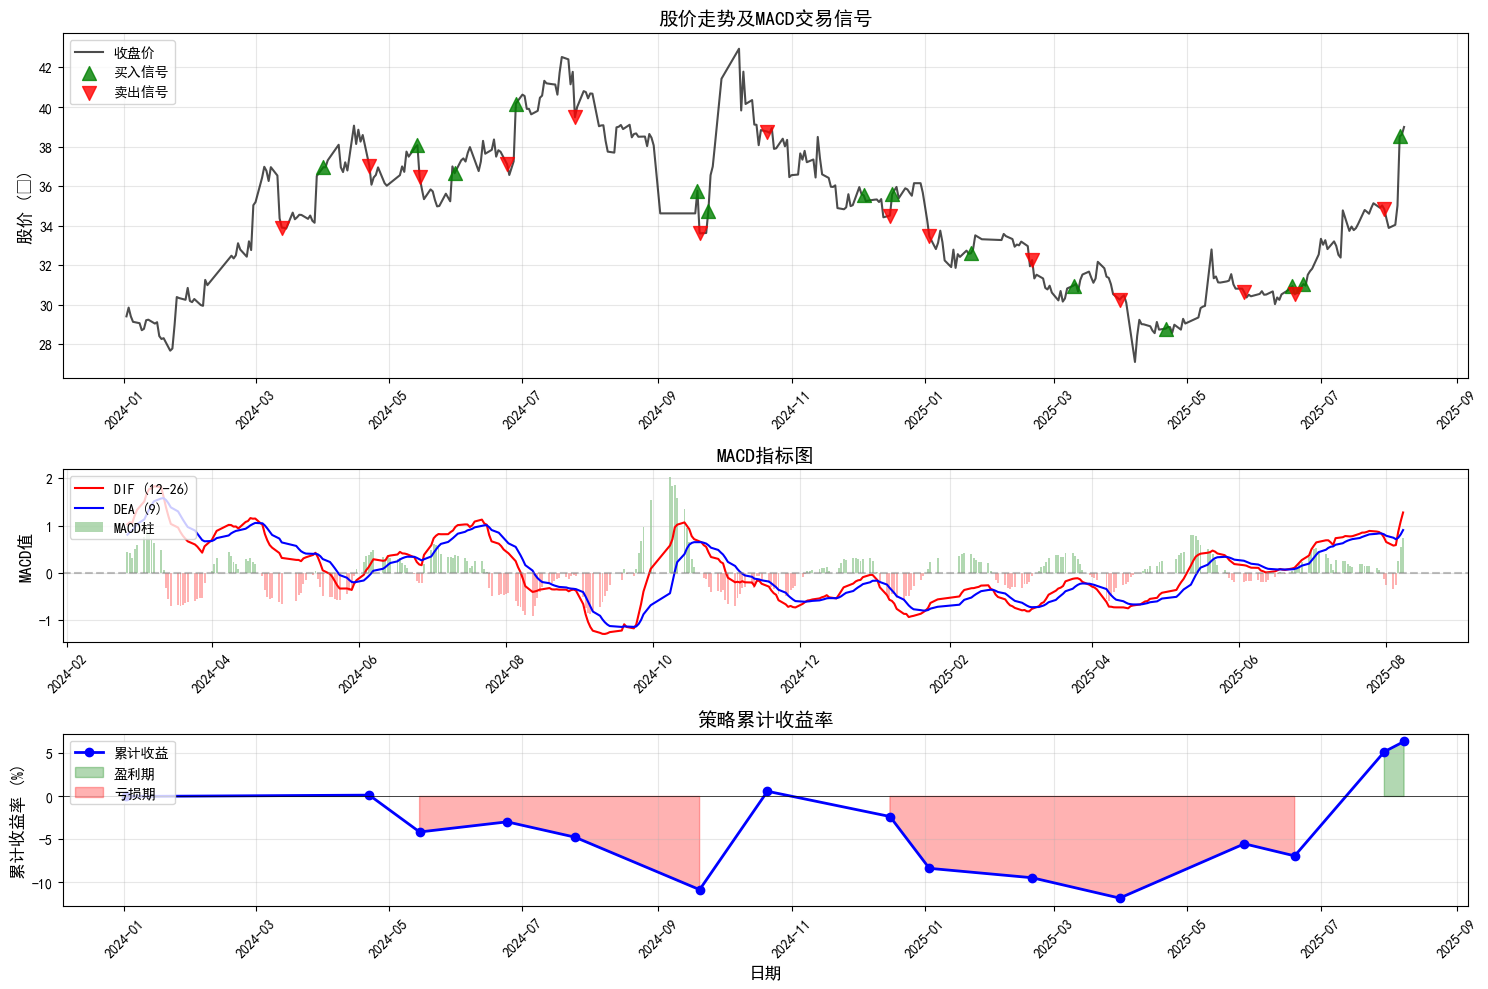

In [12]:
# ============================================
# Cell 8: 可视化 - 股价和MACD图表
# ============================================
"""
📊 第六步：可视化分析结果
通过图表直观理解MACD策略的运作
"""

def plot_macd_strategy(df, buy_signals, sell_signals, trades, figsize=(15, 10)):
    """
    绘制MACD策略的完整图表
    """
    fig, axes = plt.subplots(3, 1, figsize=figsize, height_ratios=[2, 1, 1])
    
    # ========== 图1: 股价走势和交易信号 ==========
    ax1 = axes[0]
    
    # 绘制价格线
    ax1.plot(df['date'], df['close'], label='收盘价', color='black', linewidth=1.5, alpha=0.7)
    
    # 标记买入点
    if buy_signals:
        buy_dates = [s['date'] for s in buy_signals]
        buy_prices = [s['price'] for s in buy_signals]
        ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                   s=100, label='买入信号', zorder=5, alpha=0.8)
    
    # 标记卖出点
    if sell_signals:
        sell_dates = [s['date'] for s in sell_signals]
        sell_prices = [s['price'] for s in sell_signals]
        ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                   s=100, label='卖出信号', zorder=5, alpha=0.8)
    
    ax1.set_title('股价走势及MACD交易信号', fontsize=14, fontweight='bold')
    ax1.set_ylabel('股价 (¥)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # ========== 图2: MACD指标 ==========
    ax2 = axes[1]
    
    # 绘制DIF和DEA线
    valid_data = df.dropna(subset=['dif', 'dea'])
    ax2.plot(valid_data['date'], valid_data['dif'], 
             label=f'DIF ({MACD_PARAMS["fast_period"]}-{MACD_PARAMS["slow_period"]})', 
             color='red', linewidth=1.5)
    ax2.plot(valid_data['date'], valid_data['dea'], 
             label=f'DEA ({MACD_PARAMS["signal_period"]})', 
             color='blue', linewidth=1.5)
    
    # 绘制MACD柱状图
    colors = ['green' if x > 0 else 'red' for x in valid_data['macd_hist']]
    ax2.bar(valid_data['date'], valid_data['macd_hist'], 
            color=colors, alpha=0.3, label='MACD柱')
    
    # 添加零轴线
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    ax2.set_title('MACD指标图', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MACD值', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # ========== 图3: 累计收益曲线 ==========
    ax3 = axes[2]
    
    # 计算累计收益
    complete_trades = [t for t in trades if t['type'] == 'sell']
    if complete_trades:
        dates = [t['date'] for t in complete_trades]
        cumulative_returns = []
        cum_return = 0
        
        for trade in complete_trades:
            cum_return += trade['return_pct']
            cumulative_returns.append(cum_return)
        
        # 添加起始点
        dates = [df['date'].iloc[0]] + dates
        cumulative_returns = [0] + cumulative_returns
        
        # 绘制累计收益曲线
        ax3.plot(dates, cumulative_returns, marker='o', 
                color='blue', linewidth=2, markersize=6, label='累计收益')
        
        # 填充颜色
        ax3.fill_between(dates, 0, cumulative_returns, 
                        where=[r >= 0 for r in cumulative_returns], 
                        color='green', alpha=0.3, label='盈利期')
        ax3.fill_between(dates, 0, cumulative_returns, 
                        where=[r < 0 for r in cumulative_returns], 
                        color='red', alpha=0.3, label='亏损期')
    
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_title('策略累计收益率', fontsize=14, fontweight='bold')
    ax3.set_xlabel('日期', fontsize=12)
    ax3.set_ylabel('累计收益率 (%)', fontsize=12)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 设置日期格式
    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# 绘制图表
plot_macd_strategy(
    stock_data, 
    buy_signals, 
    sell_signals, 
    trades,
    figsize=DISPLAY_PARAMS['figure_size']
)

In [15]:
# ============================================
# Cell 9: 参数优化实验
# ============================================
"""
🔬 第七步：参数优化 - 找到最佳的MACD参数组合

这个过程会测试不同的参数组合，找出收益最高的设置
⚠️ 注意：过度优化可能导致过拟合！
"""

def optimize_macd_parameters(df, fast_range=(8, 16), slow_range=(20, 30), signal_range=(6, 12)):
    """
    网格搜索最优MACD参数
    """
    print("🔍 开始参数优化...")
    print(f"测试范围：")
    print(f"  快线: {fast_range[0]}-{fast_range[1]}")
    print(f"  慢线: {slow_range[0]}-{slow_range[1]}")
    print(f"  信号线: {signal_range[0]}-{signal_range[1]}")
    print("-"*50)
    
    results = []
    best_return = -float('inf')
    best_params = None
    
    # 遍历所有参数组合
    for fast in range(fast_range[0], fast_range[1]+1, 2):  # 步长为2，减少计算量
        for slow in range(slow_range[0], slow_range[1]+1, 2):
            if fast >= slow:  # 快线必须小于慢线
                continue
                
            for signal in range(signal_range[0], signal_range[1]+1, 2):
                # 计算MACD
                df_test = df.copy()
                df_test = calculate_macd(df_test, fast, slow, signal)
                
                # 生成信号
                df_test, buy_sigs, sell_sigs = generate_trading_signals(df_test)
                
                # 回测
                if buy_sigs and sell_sigs:  # 确保有交易信号
                    trades_test, perf = backtest_strategy(
                        df_test, buy_sigs, sell_sigs, BACKTEST_PARAMS
                    )
                    
                    total_return = perf['total_return']
                    
                    # 记录结果
                    results.append({
                        'fast': fast,
                        'slow': slow,
                        'signal': signal,
                        'return': total_return,
                        'trades': len([t for t in trades_test if t['type'] == 'sell'])
                    })
                    
                    # 更新最佳参数
                    if total_return > best_return:
                        best_return = total_return
                        best_params = {'fast': fast, 'slow': slow, 'signal': signal}
    
    # 转换为DataFrame便于分析
    results_df = pd.DataFrame(results)
    
    print(f"\n✅ 测试完成！共测试了 {len(results)} 种参数组合")
    
    if best_params:
        print(f"\n🏆 最优参数组合：")
        print(f"  快线周期: {best_params['fast']}")
        print(f"  慢线周期: {best_params['slow']}")
        print(f"  信号线周期: {best_params['signal']}")
        print(f"  预期收益率: {best_return:.2f}%")
    
    # 显示前10个最佳组合
    print("\n📊 收益率TOP 10的参数组合：")
    top10 = results_df.nlargest(10, 'return')
    print(top10.to_string(index=False))
    
    return results_df, best_params

# 运行参数优化（可选）
optimize = input("\n是否进行参数优化？这可能需要几分钟时间 (y/n): ")
if optimize.lower() == 'y':
    optimization_results, best_params = optimize_macd_parameters(
        stock_data,
        fast_range=(10, 14),
        slow_range=(24, 28),
        signal_range=(8, 10)
    )

🔍 开始参数优化...
测试范围：
  快线: 10-14
  慢线: 24-28
  信号线: 8-10
--------------------------------------------------

🔄 计算MACD指标 (快线:10, 慢线:24, 信号:8)
✅ MACD计算完成，有效数据点: 365/388

🔍 识别交易信号...
✅ 找到 15 个买入信号（金叉）
✅ 找到 15 个卖出信号（死叉）

最近的买入信号: 2025-08-06 @ ¥38.51
最近的卖出信号: 2025-07-30 @ ¥34.82

🚀 开始回测...

🔄 计算MACD指标 (快线:10, 慢线:24, 信号:10)
✅ MACD计算完成，有效数据点: 365/388

🔍 识别交易信号...
✅ 找到 14 个买入信号（金叉）
✅ 找到 14 个卖出信号（死叉）

最近的买入信号: 2025-08-06 @ ¥38.51
最近的卖出信号: 2025-07-30 @ ¥34.82

🚀 开始回测...

🔄 计算MACD指标 (快线:10, 慢线:26, 信号:8)
✅ MACD计算完成，有效数据点: 363/388

🔍 识别交易信号...
✅ 找到 17 个买入信号（金叉）
✅ 找到 17 个卖出信号（死叉）

最近的买入信号: 2025-08-06 @ ¥38.51
最近的卖出信号: 2025-07-30 @ ¥34.82

🚀 开始回测...

🔄 计算MACD指标 (快线:10, 慢线:26, 信号:10)
✅ MACD计算完成，有效数据点: 363/388

🔍 识别交易信号...
✅ 找到 14 个买入信号（金叉）
✅ 找到 14 个卖出信号（死叉）

最近的买入信号: 2025-08-06 @ ¥38.51
最近的卖出信号: 2025-07-30 @ ¥34.82

🚀 开始回测...

🔄 计算MACD指标 (快线:10, 慢线:28, 信号:8)
✅ MACD计算完成，有效数据点: 361/388

🔍 识别交易信号...
✅ 找到 16 个买入信号（金叉）
✅ 找到 16 个卖出信号（死叉）

最近的买入信号: 2025-08-06 @ ¥38.51
最近的卖出信号: 2025-07-30 @ ¥34.82

🚀 开始回测...

🔄 

In [16]:
# ============================================
# Cell 10: 学习总结和要点
# ============================================
"""
📚 MACD策略学习总结
"""

print("="*60)
print("📚 MACD策略学习要点总结")
print("="*60)

print("""
1️⃣ MACD指标的原理：
   - MACD是趋势跟踪指标，通过快慢均线的差值判断趋势
   - DIF = 短期EMA - 长期EMA（反映价格动量）
   - DEA = DIF的EMA平滑（信号线）
   - 金叉买入，死叉卖出

2️⃣ 回测的重要性：
   - 用历史数据验证策略的有效性
   - 考虑交易成本（手续费、滑点）
   - 评估风险收益比

3️⃣ 策略的优缺点：
   ✅ 优点：
   - 能捕捉中长期趋势
   - 信号明确，易于执行
   - 适合趋势明显的市场
   
   ❌ 缺点：
   - 滞后性（基于历史数据）
   - 震荡市场表现不佳
   - 可能产生假信号

4️⃣ 改进方向：
   - 结合其他指标（RSI、布林带等）
   - 加入止损止盈机制
   - 动态调整仓位管理
   - 考虑市场环境（牛市/熊市）

5️⃣ 风险提示：
   ⚠️ 历史表现不代表未来
   ⚠️ 参数过度优化可能导致过拟合
   ⚠️ 实盘交易还需考虑心理因素
   ⚠️ 市场环境变化可能使策略失效
""")

# 显示当前策略的关键指标
if trade_stats:
    print("\n" + "="*60)
    print("📊 本次回测的关键指标")
    print("="*60)
    print(f"策略胜率: {trade_stats['win_rate']:.1f}%")
    print(f"平均收益: {trade_stats['avg_return']:.2f}%")
    print(f"交易次数: {trade_stats['total_trades']} 次")
    print(f"总收益率: {performance['total_return']:.2f}%")
    
    # 计算年化收益率（简化计算）
    days = (stock_data['date'].max() - stock_data['date'].min()).days
    years = days / 365
    annualized_return = (((performance['final_capital'] / performance['initial_capital']) ** (1/years)) - 1) * 100
    print(f"年化收益: {annualized_return:.2f}%")

print("\n💡 建议：在实际使用前，请在更长的历史数据上测试，并考虑不同市场环境下的表现。")

📚 MACD策略学习要点总结

1️⃣ MACD指标的原理：
   - MACD是趋势跟踪指标，通过快慢均线的差值判断趋势
   - DIF = 短期EMA - 长期EMA（反映价格动量）
   - DEA = DIF的EMA平滑（信号线）
   - 金叉买入，死叉卖出

2️⃣ 回测的重要性：
   - 用历史数据验证策略的有效性
   - 考虑交易成本（手续费、滑点）
   - 评估风险收益比

3️⃣ 策略的优缺点：
   ✅ 优点：
   - 能捕捉中长期趋势
   - 信号明确，易于执行
   - 适合趋势明显的市场

   ❌ 缺点：
   - 滞后性（基于历史数据）
   - 震荡市场表现不佳
   - 可能产生假信号

4️⃣ 改进方向：
   - 结合其他指标（RSI、布林带等）
   - 加入止损止盈机制
   - 动态调整仓位管理
   - 考虑市场环境（牛市/熊市）

5️⃣ 风险提示：
   ⚠️ 历史表现不代表未来
   ⚠️ 参数过度优化可能导致过拟合
   ⚠️ 实盘交易还需考虑心理因素
   ⚠️ 市场环境变化可能使策略失效


📊 本次回测的关键指标
策略胜率: 42.9%
平均收益: 0.46%
交易次数: 14 次
总收益率: 4.41%
年化收益: 2.74%

💡 建议：在实际使用前，请在更长的历史数据上测试，并考虑不同市场环境下的表现。


In [ ]:
# ============================================
# Cell 11: 保存结果（可选）
# ============================================
"""
💾 保存回测结果供后续分析
"""

def save_results(stock_data, trades, performance, filename_prefix='macd_backtest'):
    """
    保存回测结果到文件
    """
    import os
    from datetime import datetime
    
    # 创建结果文件夹
    if not os.path.exists('backtest_results'):
        os.makedirs('backtest_results')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. 保存交易记录
    if trades:
        trades_df = pd.DataFrame([t for t in trades if t['type'] == 'sell'])
        trades_file = f'backtest_results/{filename_prefix}_trades_{timestamp}.xlsx'
        trades_df.to_excel(trades_file, index=False)
        print(f"✅ 交易记录已保存到: {trades_file}")
    
    # 2. 保存性能指标
    perf_file = f'backtest_results/{filename_prefix}_performance_{timestamp}.txt'
    with open(perf_file, 'w', encoding='utf-8') as f:
        f.write("MACD策略回测报告\n")
        f.write("="*50 + "\n")
        f.write(f"生成时间: {datetime.now()}\n")
        f.write(f"数据范围: {stock_data['date'].min()} 至 {stock_data['date'].max()}\n")
        f.write(f"MACD参数: 快线={MACD_PARAMS['fast_period']}, 慢线={MACD_PARAMS['slow_period']}, 信号线={MACD_PARAMS['signal_period']}\n")
        f.write("\n性能指标:\n")
        f.write(f"初始资金: ¥{performance['initial_capital']:,.2f}\n")
        f.write(f"最终资金: ¥{performance['final_capital']:,.2f}\n")
        f.write(f"总收益率: {performance['total_return']:.2f}%\n")
        f.write(f"总手续费: ¥{performance['total_commission']:,.2f}\n")
        
        if trade_stats:
            f.write(f"\n交易统计:\n")
            f.write(f"总交易次数: {trade_stats['total_trades']}\n")
            f.write(f"胜率: {trade_stats['win_rate']:.1f}%\n")
            f.write(f"平均收益: {trade_stats['avg_return']:.2f}%\n")
    
    print(f"✅ 性能报告已保存到: {perf_file}")
    
    # 3. 保存带信号的数据
    data_file = f'backtest_results/{filename_prefix}_data_{timestamp}.xlsx'
    stock_data.to_excel(data_file, index=False)
    print(f"✅ 完整数据已保存到: {data_file}")

# 询问是否保存
save = input("\n是否保存回测结果？(y/n): ")
if save.lower() == 'y':
    save_results(stock_data, trades, performance)